In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-08-08 11:42:33.681434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/catarinavuzi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### **Model performance**

- The model does not perfom really well as we can see the accuracy percentage is low and the loss is high.

- Surprisingly, the accuracy score is even lower after the transfer learning in the first scores but is goes up towards the end.

- On the Visualization the training  accuracy of the model before the transfer learning shows a weird line that goes up down that is a little hard to interpret.

- After the transfer learning the on the second visualization  both lines are plotted against each other and they bothgo up and down. Based on that, it seems like it is having hard time learning. 

In [2]:
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/Users/catarinavuzi/Downloads/cracked_uncracked_images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 40 files for validation.


2024-08-08 11:42:47.495846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


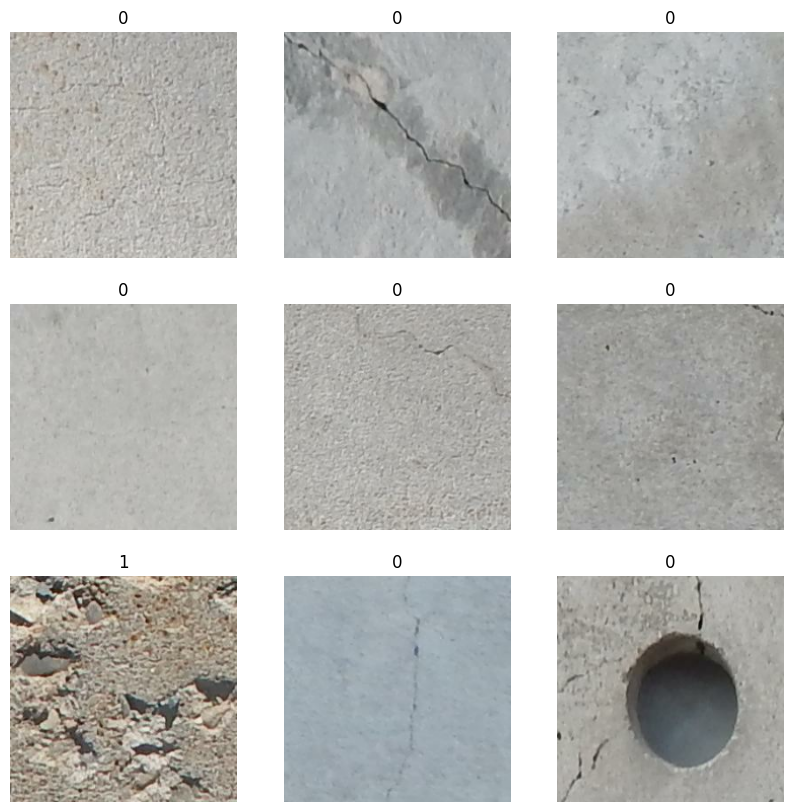

In [3]:
##Taking a look to the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2024-08-08 11:43:09.645310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


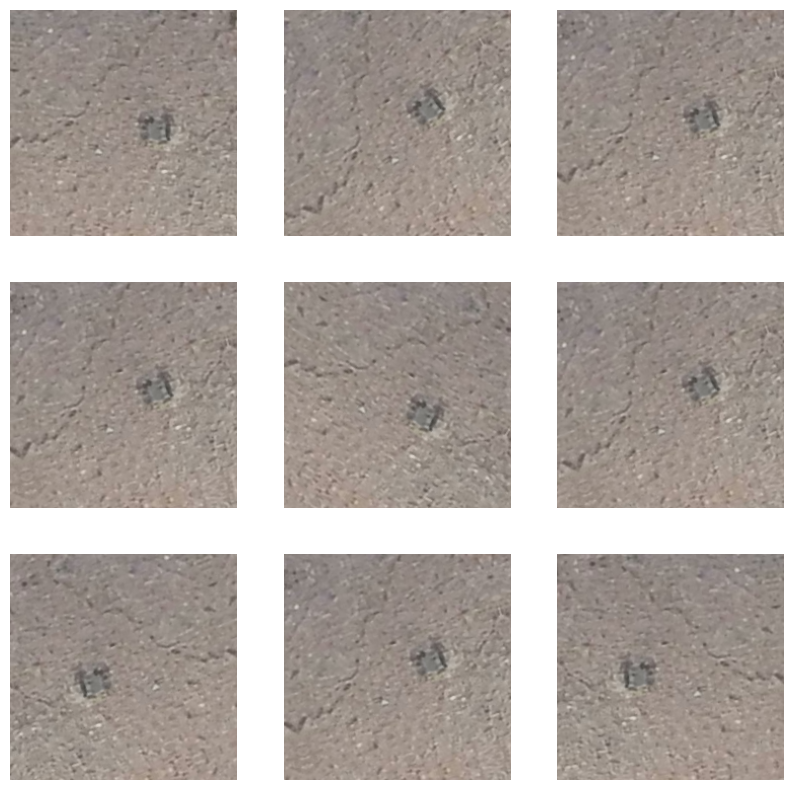

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [8]:
def make_model_1(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model_1(input_shape=image_size + (3,), num_classes=2)
##keras.utils.plot_model(model, show_shapes=True)

In [9]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - acc: 0.5014 - loss: 0.9196 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - acc: 0.5693 - loss: 0.7249 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5560 - loss: 0.7577 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5528 - loss: 0.7198 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - acc: 0.5646 - loss: 0.6822 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - acc: 0.5224 - loss: 0.7227 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - acc: 0.6225 - loss: 0.6629 - val_acc: 0.5000 - val_loss: 0.6935
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - acc: 0.5616 - loss: 0.7552 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - acc: 0.5439 - loss: 

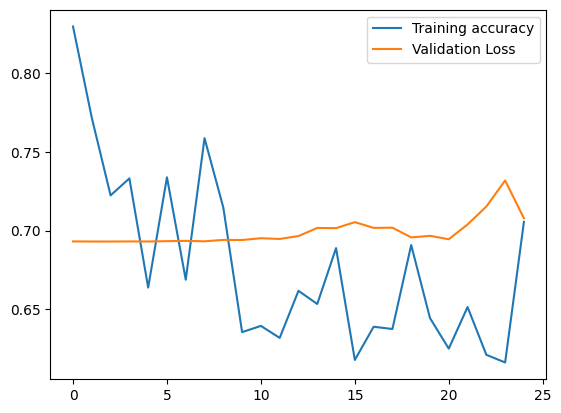

In [10]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training accuracy")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

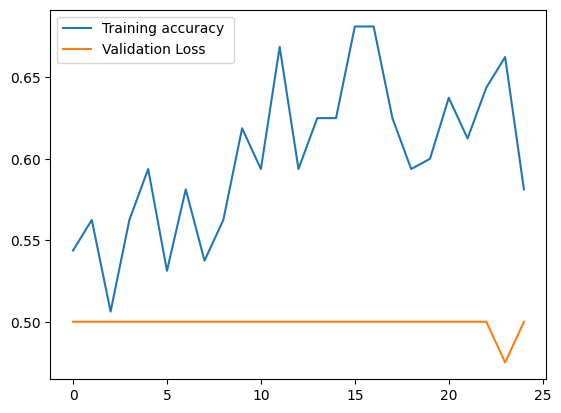

In [11]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training accuracy ")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [13]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [14]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [15]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 485ms/step - acc: 0.4873 - loss: 1.3322 - val_acc: 0.5000 - val_loss: 0.8759
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - acc: 0.4860 - loss: 0.8130 - val_acc: 0.5000 - val_loss: 0.7235
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - acc: 0.6005 - loss: 0.7131 - val_acc: 0.5250 - val_loss: 0.7071
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step - acc: 0.5107 - loss: 0.7409 - val_acc: 0.5250 - val_loss: 0.6765
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - acc: 0.5550 - loss: 0.7012 - val_acc: 0.5750 - val_loss: 0.6593
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 418ms/step - acc: 0.4918 - loss: 0.7345 - val_acc: 0.6250 - val_loss: 0.6432
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - acc: 0.5730 - loss: 0.6765 - val_acc: 0.5750 - val_loss: 0.6327
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - acc: 0.5303 - loss: 0.6701 - val_acc: 0.6000 - val_loss: 0.6210
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - a

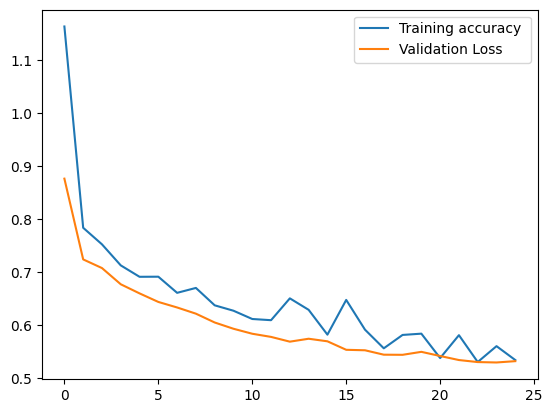

In [16]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training accuracy ")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

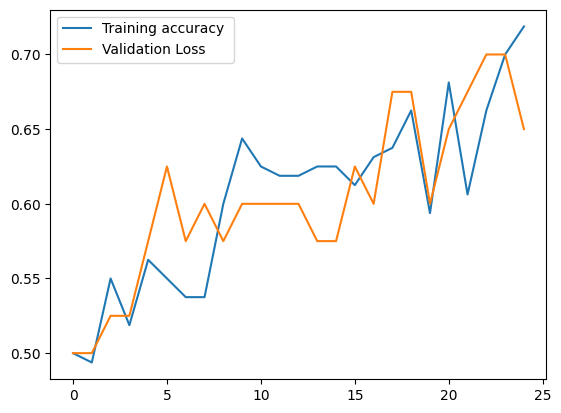

In [17]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training accuracy ")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [19]:
# Save the model
model.save('make_model_1.keras') # Use .keras or .h5 extension

# Load the model
loaded_model = keras.models.load_model('make_model_1.keras')